In [1]:
cd ..

/Users/joeranbosma/stack/Projects/M5Forecast/uncertainty


In [2]:
cd ..

/Users/joeranbosma/stack/Projects/M5Forecast


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, gc
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import (Dense, Dropout, Flatten, Input, BatchNormalization, Lambda, 
                                     concatenate, Embedding, Reshape)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import Callback, LearningRateScheduler

import wandb
from wandb.keras import WandbCallback

# own imports
from evaluation import Referee, load_data, select_dates, select_day_nums
from train import (BatchCreator, Logger, plot_confidence_series, plot_some_confidence_intervals, 
                   prepare_training, perform_training_scheme)
from model_builder import (get_pinball_losses, get_simple_dist_model, get_simple_dense_model,
                           get_variable_dist_model, get_direct_dist_model, get_direct_custom_layer)
from flow import model_predict, denorm_preds, warp_preds_to_ref_form, plot_some, evaluate_model, save_object
from preprocess import (preprocess, get_features, pandas_cat_data, reset_categorical_features, 
                        read_and_preprocess_data)


# Setup file paths
data_dir = 'data/'
os.environ['DATA_DIR'] = data_dir
sub_dir = 'submissions_uncertainty/'
plt.rcParams['font.size'] = 13

# Hardcode requested quantiles
quantiles = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]

# Train MLP - trechter architecture

In [4]:
# Load in the data set
calendar, sales_train_validation, sell_prices = load_data()

sales_true = select_dates(sales_train_validation, day_end=1913, num_days=28, include_metadata=True)
sales_train = select_dates(sales_train_validation, day_start=1, num_days=1913-28, include_metadata=True)

ref = Referee(sales_true, sales_train, sell_prices, calendar, verbose=True)

Initializing Referee
Converting true sales to quantile form
Calculating weights for each level...
Calculating scale for each level...
Finished setup.


In [5]:
model_dir = 'models/uncertainty/trechter_architecture/run2/'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

## Define model architectures

In [6]:
labels = ['demand']

# Set input sizes for the model
input_shapes = {
    1: (178,),
    2: (181,),
    3: (191,),
    4: (181,),
    5: (188,),
    6: (184,),
    7: (191,),
    8: (194,),
    9: (201,),
    10: (3237,),
    11: (3240,),
    12: (3248,),
}

# Set initial batch size
warmup_batch_size = {level: 32 if level <= 9 else 1024 for level in range(1, 1+12)}

# Set fine-tune batch size
finetune_batch_size = {level: 64 if level <= 9 else 25000 for level in range(1, 1+12)}

In [7]:
def get_trechter_node_list(num_nodes_start=256, num_nodes_end=8, num_layers=4, exponent=1/3, verbose=True):
    nodes_list = []
    for i in range(num_layers+1):
        num = num_nodes_start + (i / num_layers)**exponent * (num_nodes_end - num_nodes_start)
        nodes_list.append(int(num))
    print("Trechter nodes: ", nodes_list) if verbose else None
    return nodes_list

get_trechter_node_list()

Trechter nodes:  [256, 99, 59, 30, 8]


[256, 99, 59, 30, 8]

In [8]:
def get_dense_block(x, nodes_list):
    for num in nodes_list:
        x = Dense(num, activation="relu")(x)
    return x


def get_trechter_model(inp_shape, num_nodes_start=256, num_nodes_end=8, num_layers=4, clear_session=True):
    if clear_session:
        # clear previous sessions
        K.clear_session()
    
    inp = Input(inp_shape, name="input")
    x = inp
    
    nodes_list = get_trechter_node_list(num_nodes_start, num_nodes_end, num_layers)
    x = get_dense_block(x, nodes_list)
    
    # direct prediction of median
    qm = Dense(1, name="q4", activation="exponential")(x)

    # setup parameters
    alpha = Dense(1, name="alpha", activation="sigmoid")(x)
    beta = Dense(1, name="beta", activation="sigmoid")(x)
    gamma = Dense(1, name="gamma", activation="sigmoid")(x)
    delta = Dense(1, name="delta", activation="exponential")(x)
    epsilon = Dense(1, name="epsilon", activation="sigmoid")(x)
    zeta = Dense(1, name="zeta", activation="sigmoid")(x)
    eta = Dense(1, name="eta", activation="sigmoid")(x)
    theta = Dense(1, name="theta", activation="sigmoid")(x)

    outs = []

    for i in range(9):
        if i == 4:
            out_q = qm
        else:
            custom_layer = get_direct_custom_layer(i)
            params = [qm, alpha, beta, gamma, delta, epsilon, zeta, eta, theta]
            out_q = Lambda(custom_layer, name="q{}".format(i))(params)
        outs.append(out_q)

    model = Model(inputs=inp, outputs=outs)

    return model


## Define networks

In [9]:
n0 = 32
n1 = 48
n2 = 64
# select which model function was used to build the model
models_base = {
    1: get_trechter_model(inp_shape=input_shapes[1], num_nodes_start=n0, num_nodes_end=2, clear_session=False),
    2: get_trechter_model(inp_shape=input_shapes[2], num_nodes_start=n0, num_nodes_end=2, clear_session=False),
    3: get_trechter_model(inp_shape=input_shapes[3], num_nodes_start=n0, num_nodes_end=2, clear_session=False),
    4: get_trechter_model(inp_shape=input_shapes[4], num_nodes_start=n0, num_nodes_end=6, clear_session=False),
    5: get_trechter_model(inp_shape=input_shapes[5], num_nodes_start=n0, num_nodes_end=8, clear_session=False),
    6: get_trechter_model(inp_shape=input_shapes[6], num_nodes_start=n0, num_nodes_end=8, clear_session=False),
    7: get_trechter_model(inp_shape=input_shapes[7], num_nodes_start=n1, num_nodes_end=8, clear_session=False),
    8: get_trechter_model(inp_shape=input_shapes[8], num_nodes_start=n1, num_nodes_end=9, clear_session=False),
    9: get_trechter_model(inp_shape=input_shapes[9], num_nodes_start=n2, num_nodes_end=20, clear_session=False),
}

Trechter nodes:  [32, 13, 8, 4, 2]
Trechter nodes:  [32, 13, 8, 4, 2]
Trechter nodes:  [32, 13, 8, 4, 2]
Trechter nodes:  [32, 15, 11, 8, 6]
Trechter nodes:  [32, 16, 12, 10, 8]
Trechter nodes:  [32, 16, 12, 10, 8]
Trechter nodes:  [48, 22, 16, 11, 8]
Trechter nodes:  [48, 23, 17, 12, 9]
Trechter nodes:  [64, 36, 29, 24, 20]


### Simpler training scheme: Adam(1e-3), then Adam(1e-4)

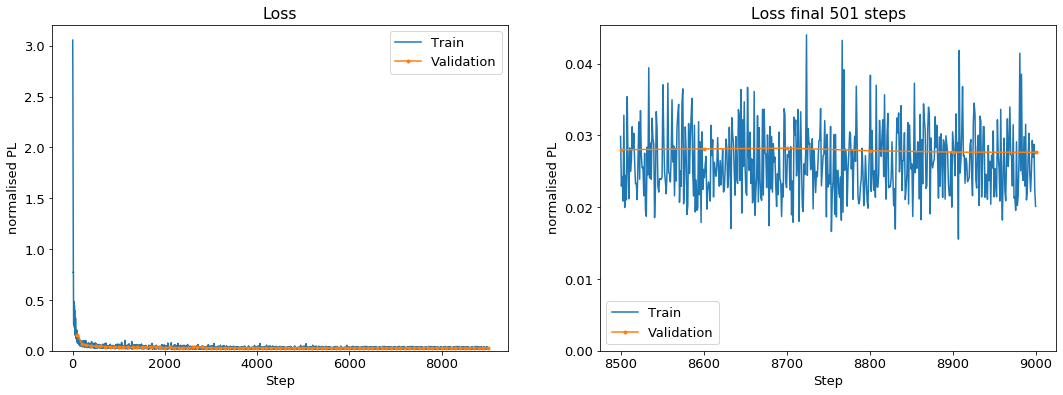

100/100 [==============================] - 4s 39ms/step - loss: 0.0265 - q0_loss: 2.3414e-04 - q1_loss: 8.6816e-04 - q2_loss: 0.0036 - q3_loss: 0.0047 - q4_loss: 0.0061 - q5_loss: 0.0052 - q6_loss: 0.0042 - q7_loss: 0.0012 - q8_loss: 3.7936e-04 - val_loss: 0.0276 - val_q0_loss: 2.5021e-04 - val_q1_loss: 9.2082e-04 - val_q2_loss: 0.0038 - val_q3_loss: 0.0050 - val_q4_loss: 0.0065 - val_q5_loss: 0.0054 - val_q6_loss: 0.0044 - val_q7_loss: 0.0011 - val_q8_loss: 3.3015e-04
Predicting...
Denormalising...
Warping predictions...
Evaluating..
{9: 0.1395312136891781, 'WSPL': 0.1395312136891781}


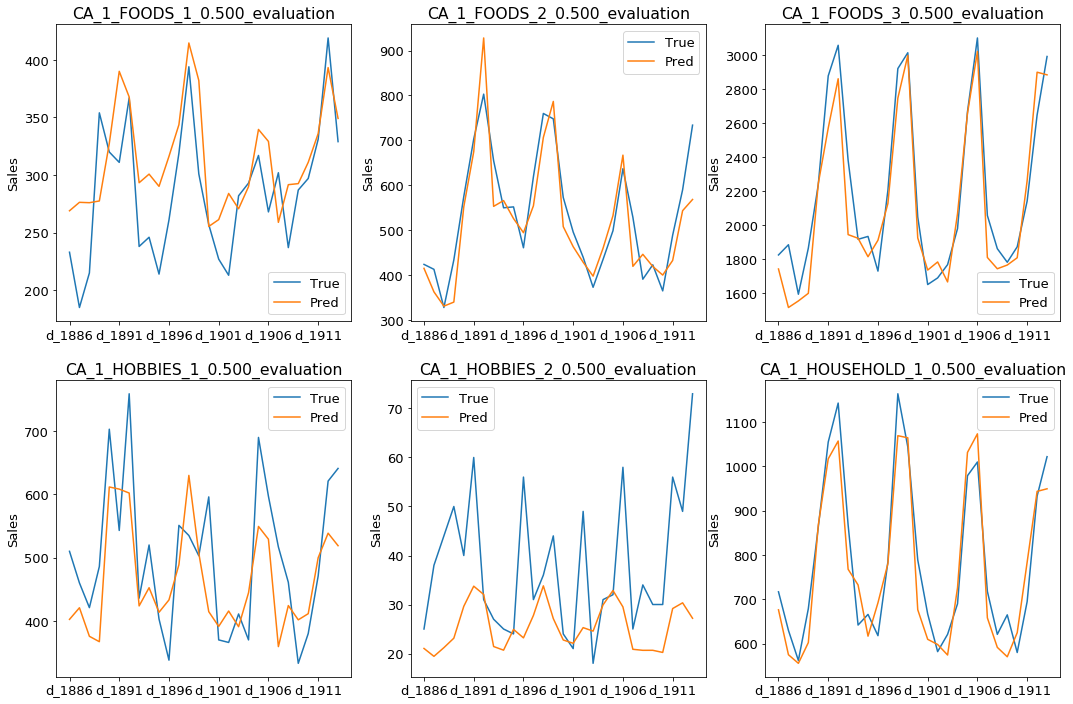

In [10]:
logger_list = []
part1_metrics = []
part2_metrics = []
part3_metrics = []

for level, model in models_base.items():
    # select model
    model = models_base[level]

    # train model
    warmup_lr_list = [1e-3, 1e-3, 1e-3, # save part 1
                      1e-4, 1e-4, 1e-4] # save part 2
    finetune_lr_list = [1e-5, 1e-5, 1e-5] # save part 3
    model, logger, metrics1, metrics2, metrics3 = perform_training_scheme(
        level, model, warmup_batch_size, finetune_batch_size, ref, calendar,
        model_dir=model_dir, warmup_lr_list=warmup_lr_list, finetune_lr_list=finetune_lr_list)
    
    # save metrics
    logger_list.append(logger); part1_metrics.append(metrics1); 
    part2_metrics.append(metrics2); part3_metrics.append(metrics3)

In [11]:
part1_metrics

[{1: 0.11258763097107721, 'WSPL': 0.11258763097107721},
 {2: 0.11197194719370862, 'WSPL': 0.11197194719370862},
 {3: 0.1262847455370582, 'WSPL': 0.1262847455370582},
 {4: 0.08395598927736261, 'WSPL': 0.08395598927736261},
 {5: 0.1332696138728708, 'WSPL': 0.1332696138728708},
 {6: 0.11981652883217005, 'WSPL': 0.11981652883217005},
 {7: 0.13370971308013424, 'WSPL': 0.13370971308013424},
 {8: 0.13871274089004296, 'WSPL': 0.13871274089004296},
 {9: 0.14783097647782062, 'WSPL': 0.14783097647782062}]

In [12]:
part2_metrics

[{1: 0.11482423284821627, 'WSPL': 0.11482423284821627},
 {2: 0.10907895062460973, 'WSPL': 0.10907895062460973},
 {3: 0.12222097363958769, 'WSPL': 0.12222097363958769},
 {4: 0.08561621238131548, 'WSPL': 0.08561621238131548},
 {5: 0.11269479193501727, 'WSPL': 0.11269479193501727},
 {6: 0.11538107728354705, 'WSPL': 0.11538107728354705},
 {7: 0.12634873956220985, 'WSPL': 0.12634873956220985},
 {8: 0.12813336378233095, 'WSPL': 0.12813336378233095},
 {9: 0.14357964532382272, 'WSPL': 0.14357964532382272}]

In [13]:
part3_metrics

[{1: 0.11699933266101492, 'WSPL': 0.11699933266101492},
 {2: 0.10853823975491592, 'WSPL': 0.10853823975491592},
 {3: 0.11953225546045246, 'WSPL': 0.11953225546045246},
 {4: 0.08681495378644613, 'WSPL': 0.08681495378644613},
 {5: 0.11263533444064994, 'WSPL': 0.11263533444064994},
 {6: 0.1161957314258048, 'WSPL': 0.1161957314258048},
 {7: 0.1260546575337832, 'WSPL': 0.1260546575337832},
 {8: 0.13034320607918895, 'WSPL': 0.13034320607918895},
 {9: 0.1395312136891781, 'WSPL': 0.1395312136891781}]

In [14]:
for i, metrics in enumerate([part1_metrics, part2_metrics, part3_metrics]):
    save_object(metrics, model_dir + "metrics_ref_part{}.pickle".format(i+1))

for i, logger in enumerate(logger_list):
    save_object(logger.train_metrics, model_dir + "metrics_train_level{}.pickle".format(i+1))
    save_object(logger.val_metrics, model_dir + "metrics_val_level{}.pickle".format(i+1))

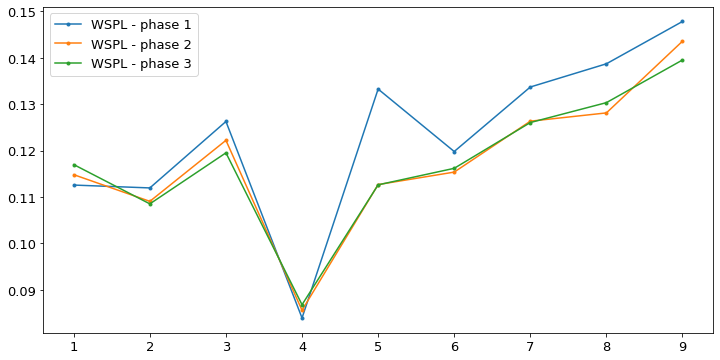

In [15]:
part1_WSPL = {list(m.keys())[0]: m['WSPL'] for m in part1_metrics}
part2_WSPL = {list(m.keys())[0]: m['WSPL'] for m in part2_metrics}
part3_WSPL = {list(m.keys())[0]: m['WSPL'] for m in part3_metrics}

f, ax = plt.subplots(1, 1, figsize=(12, 6))

for i, metrics in enumerate([part1_WSPL, part2_WSPL, part3_WSPL]):
    ax.plot(list(metrics.keys()), list(metrics.values()), '.-', label="WSPL - phase {}".format(i+1))
ax.legend()
plt.show()

Level 1


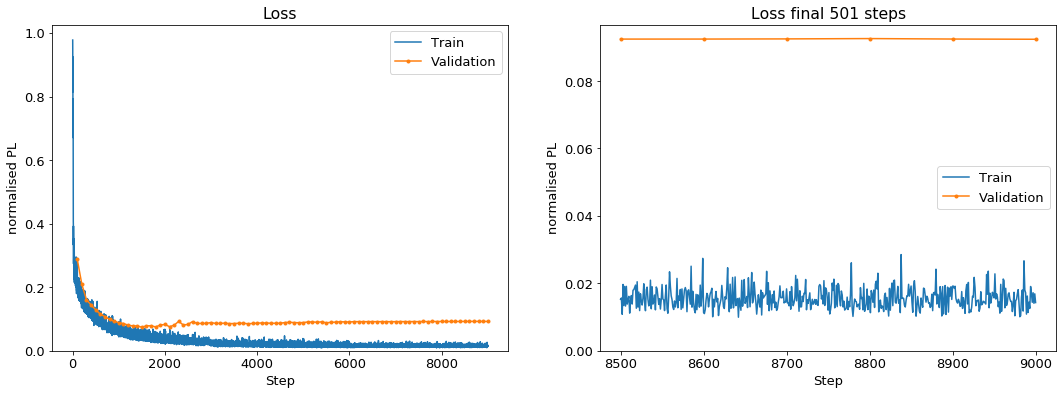

Level 2


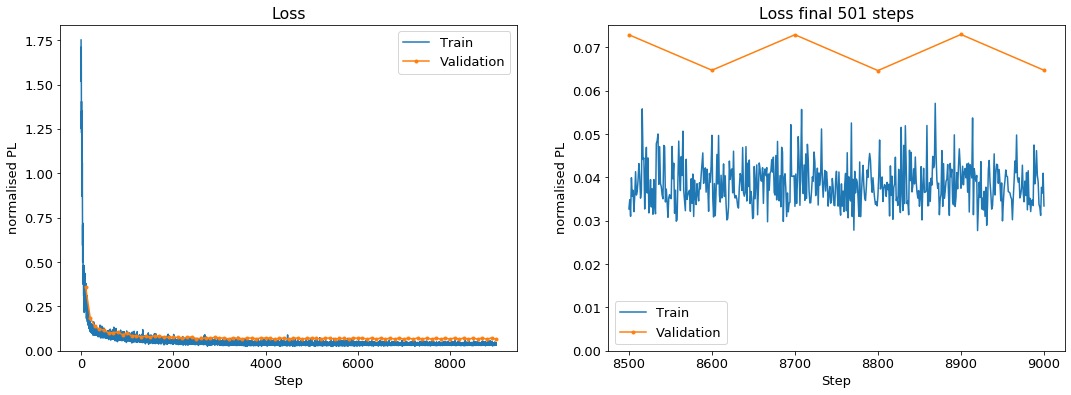

Level 3


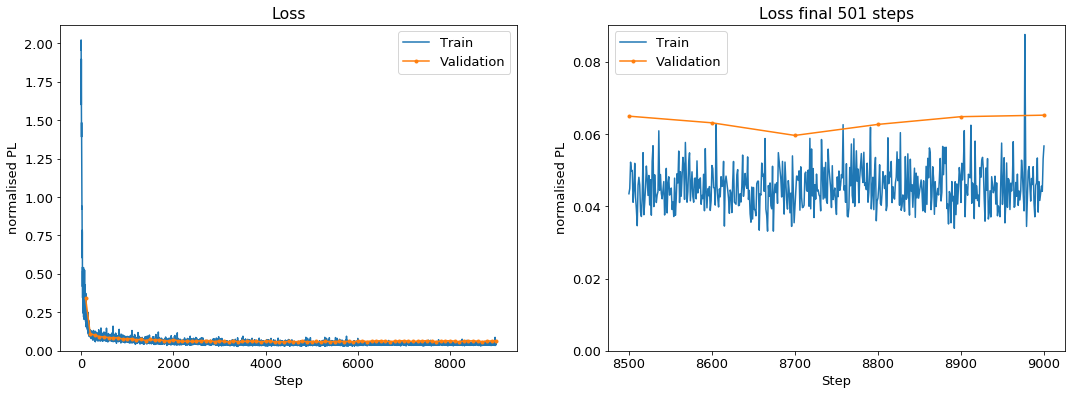

Level 4


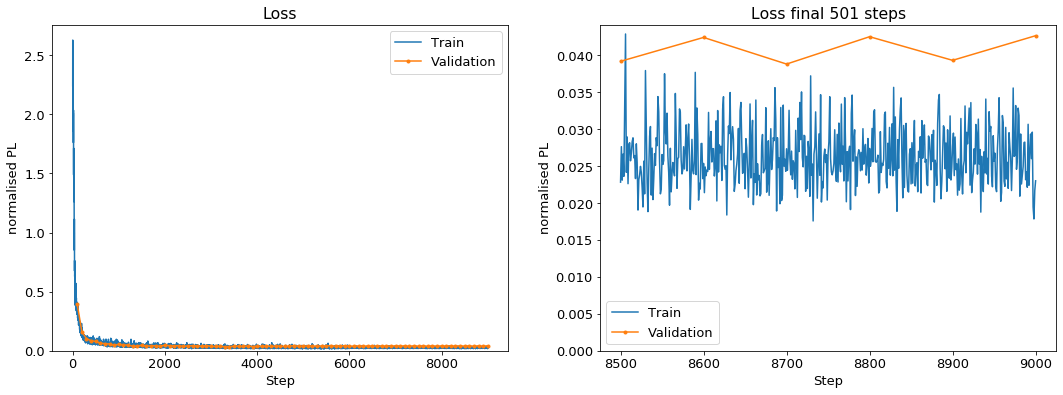

Level 5


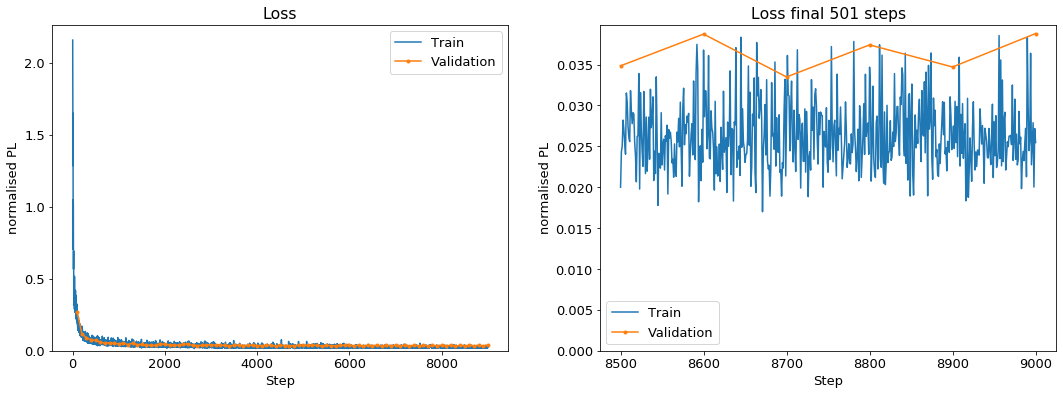

Level 6


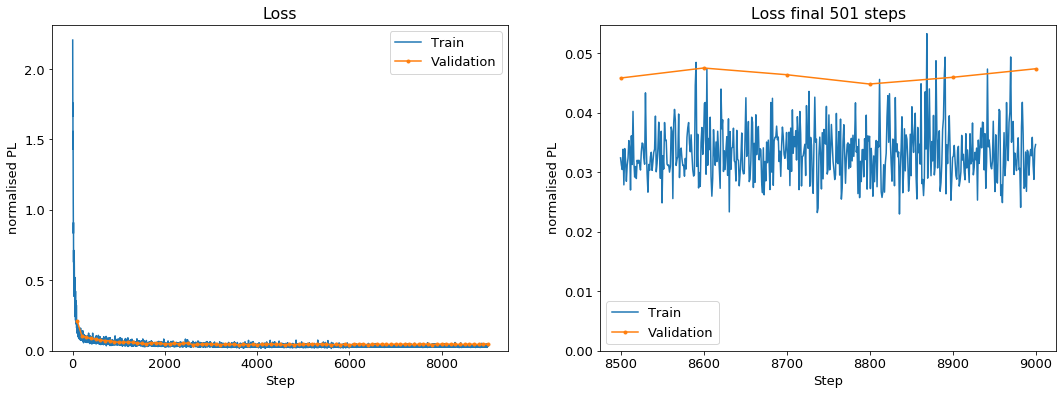

Level 7


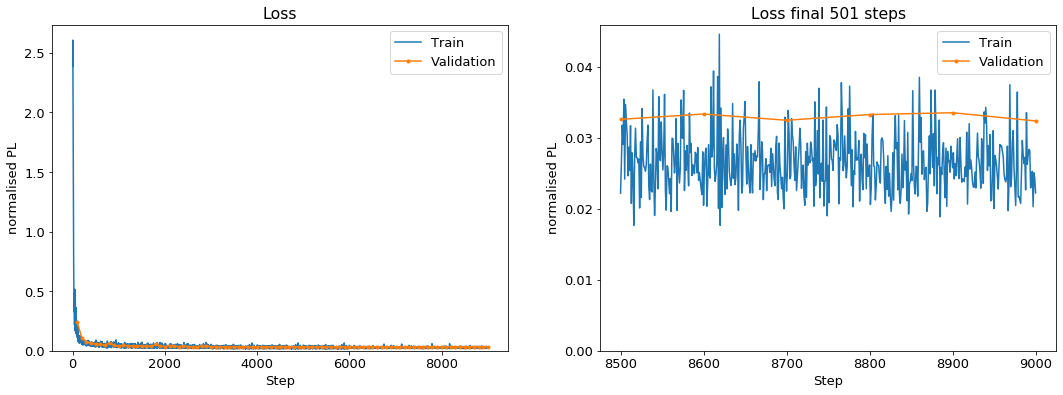

Level 8


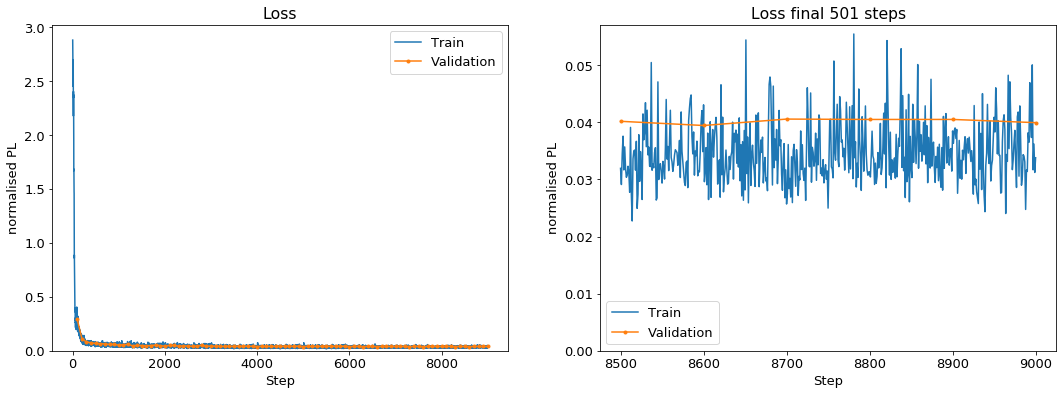

Level 9


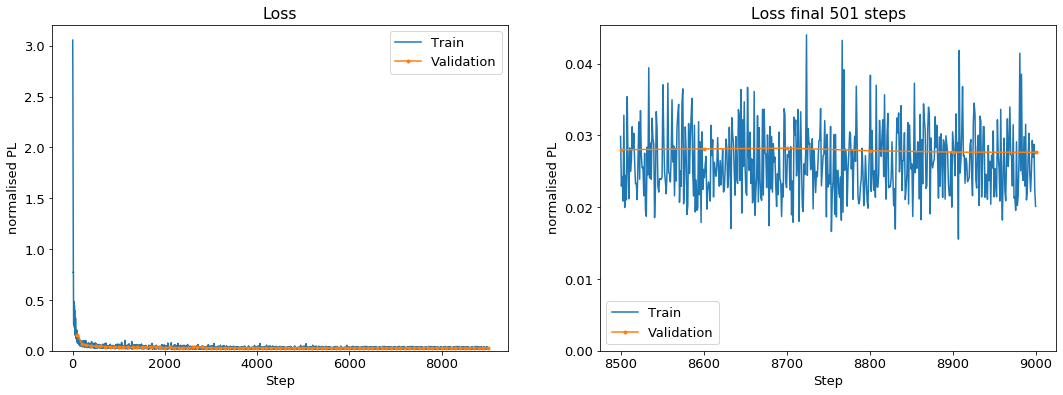

In [16]:
for i, logger in enumerate(logger_list):
    print("Level {}".format(i+1))
    logger.plot(clear=False)

### Finetune lr

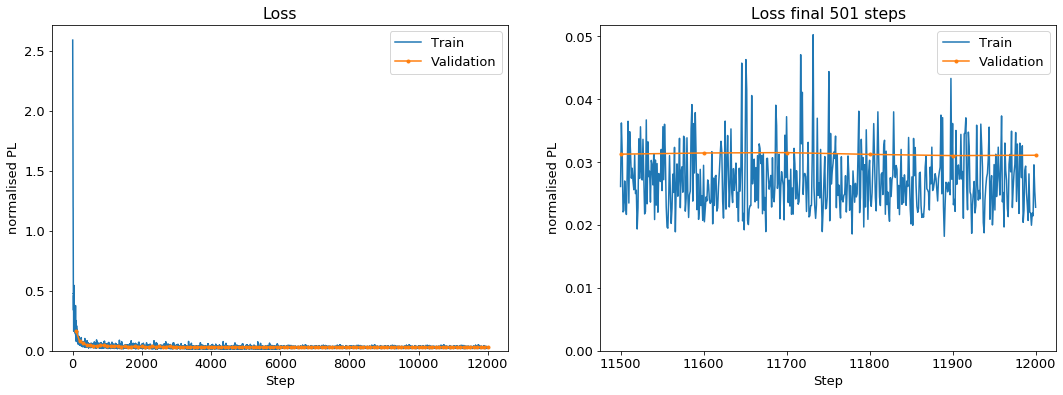

100/100 [==============================] - 4s 38ms/step - loss: 0.0269 - q0_loss: 2.5622e-04 - q1_loss: 8.7733e-04 - q2_loss: 0.0037 - q3_loss: 0.0047 - q4_loss: 0.0062 - q5_loss: 0.0053 - q6_loss: 0.0043 - q7_loss: 0.0013 - q8_loss: 4.0002e-04 - val_loss: 0.0311 - val_q0_loss: 2.7499e-04 - val_q1_loss: 0.0010 - val_q2_loss: 0.0046 - val_q3_loss: 0.0058 - val_q4_loss: 0.0072 - val_q5_loss: 0.0058 - val_q6_loss: 0.0047 - val_q7_loss: 0.0013 - val_q8_loss: 4.0578e-04
Predicting...
Denormalising...
Warping predictions...
Evaluating..
{9: 0.15642933540576054, 'WSPL': 0.15642933540576054}


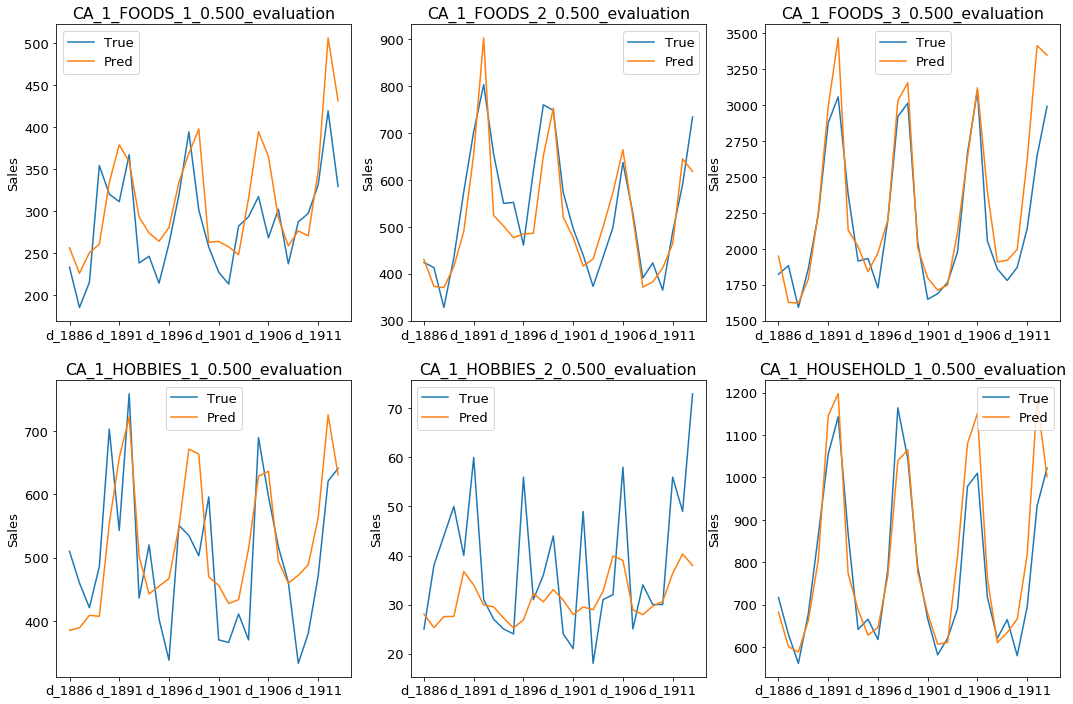

In [17]:
level = 9
finetune_batch_size = {level: 64 for level in range(1, 1+12)}
options = [[1e-5, 1e-6, 1e-7],
          [1e-5, 1e-5, 1e-6, 1e-6, 1e-7, 1e-7]]
logger_list = []
part1_metrics = []
part2_metrics = []
part3_metrics = []

for finetune_lr_list in options:
    # build model
    model = get_trechter_model(inp_shape=input_shapes[level], num_nodes_start=n1, num_nodes_end=16, clear_session=True)

    # train model
    warmup_lr_list = [1e-3, 1e-3, 1e-3, # save part 1
                      1e-4, 1e-4, 1e-4] # save part 2
    model, logger, metrics1, metrics2, metrics3 = perform_training_scheme(
        level, model, warmup_batch_size, finetune_batch_size, ref, calendar,
        model_dir=model_dir, model_name="level9_lr3-is-{}".format(finetune_lr_list[2]), 
        warmup_lr_list=warmup_lr_list, finetune_lr_list=finetune_lr_list
    )
    
    # save metrics
    logger_list.append(logger); part1_metrics.append(metrics1); 
    part2_metrics.append(metrics2); part3_metrics.append(metrics3)

In [18]:
part1_metrics

[{9: 0.1575618153682754, 'WSPL': 0.1575618153682754},
 {9: 0.17477056002735816, 'WSPL': 0.17477056002735816}]

In [19]:
part2_metrics

[{9: 0.15186003799899653, 'WSPL': 0.15186003799899653},
 {9: 0.16573511268501576, 'WSPL': 0.16573511268501576}]

In [20]:
part3_metrics

[{9: 0.15247829982845787, 'WSPL': 0.15247829982845787},
 {9: 0.15642933540576054, 'WSPL': 0.15642933540576054}]

In [21]:
for i, metrics in enumerate([part1_metrics, part2_metrics, part3_metrics]):
    save_object(metrics, model_dir + "metrics_ref_lr_part{}.pickle".format(i+1))

for i, logger in enumerate(logger_list):
    save_object(logger.train_metrics, model_dir + "metrics_train_lr_level{}.pickle".format(i+1))
    save_object(logger.val_metrics, model_dir + "metrics_val_lr_level{}.pickle".format(i+1))

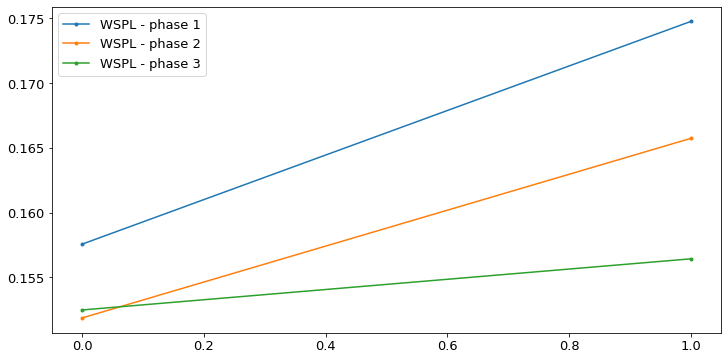

In [22]:
labels = ['short', 'long']
part1_WSPL = {labels[i]: m['WSPL'] for i, m in enumerate(part1_metrics)}
part2_WSPL = {labels[i]: m['WSPL'] for i, m in enumerate(part2_metrics)}
part3_WSPL = {labels[i]: m['WSPL'] for i, m in enumerate(part3_metrics)}

f, ax = plt.subplots(1, 1, figsize=(12, 6))
n = len(part1_WSPL)
for i, metrics in enumerate([part1_WSPL, part2_WSPL, part3_WSPL]):
    ax.plot(range(n), list(metrics.values()), '.-', label="WSPL - phase {}".format(i+1))
ax.set_xticks(range(n), labels)
ax.legend()
plt.show()

Lr list [1e-05, 1e-06, 1e-07]


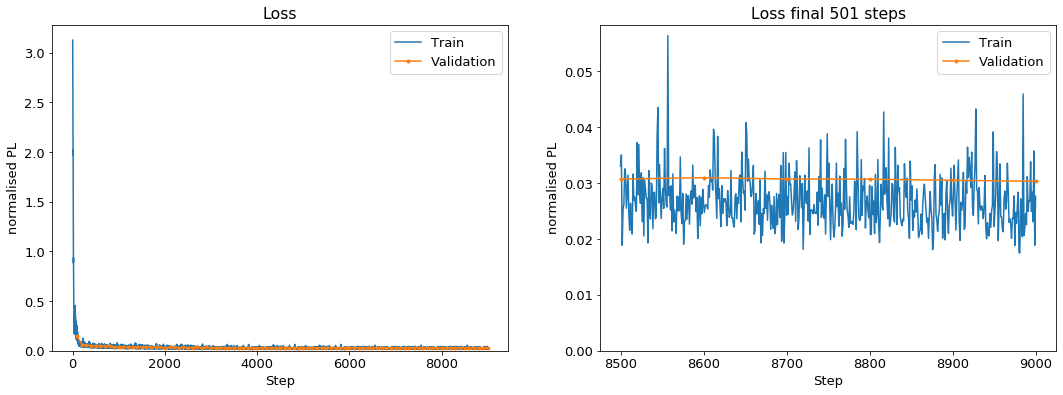

Lr list [1e-05, 1e-05, 1e-06, 1e-06, 1e-07, 1e-07]


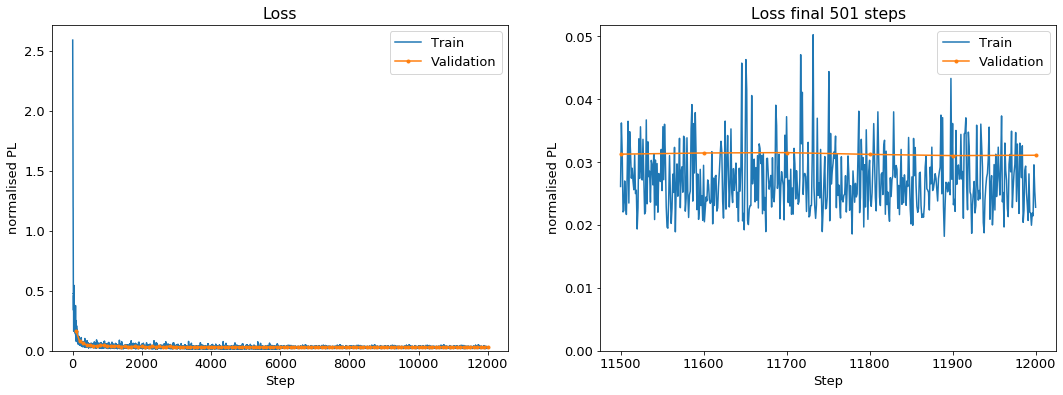

In [23]:
for i, logger in enumerate(logger_list):
    print("Lr list {}".format(options[i]))
    logger.plot(clear=False)